# Exercise - denoising

Use the Fashion MNIST data to solve this exercise. Load the images. Then, create a version of the images where artificial noise is added. Your main objective is to remove this noise.

1. Using an autoencoder where the input is the noisy images and the output is the original images, attempt to remove the noise. Note how this is essentially a supervised task.
1. Suppose you only have access to original images (i.e. without noise) for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the *noisy* test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.
1. Suppose you no longer have access to original images (i.e. without noise) but only the noisy images for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the noisy test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.

**Hint**: Consider looking at https://www.tensorflow.org/tutorials/generative/autoencoder, as they go through some of the same steps.

**Hint**: See https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose for details on transposed convolutions.

**See slides for more details!**

# Setup

This is simply some code to prepare the data. Mostly similar to https://www.tensorflow.org/tutorials/generative/autoencoder.

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train, x_test = x_train / 255, x_test / 255

x_train = x_train.reshape((*x_train.shape, 1))
x_test = x_test.reshape((*x_test.shape, 1))

In [2]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

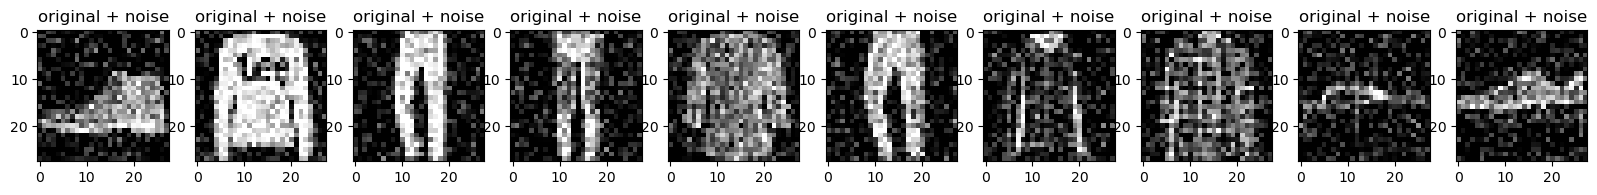

In [3]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

# Exercise 1

Using an autoencoder where the input is the noisy images and the output is the original images, attempt to remove the noise. Note how this is essentially a supervised task.

Below is the autoencoder from https://www.tensorflow.org/tutorials/generative/autoencoder.

In [4]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', strides=2, input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
], name='encoder')
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same', input_shape=(7, 7, 8)),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same'),
], name='decoder')

In [5]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 7, 7, 8)           1320      
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [6]:
autoencoder.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 20s 8ms/step - loss: 0.0160 - val_loss: 0.0091
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 8/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 9/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/10
1875/1875 [==============================] - 16s 9ms/step - l

Let us denoise the test images.

In [7]:
denoised_images = autoencoder.predict(x_test_noisy)

Finally, let us show the results. Not too bad!

However, this problem was also fully supervised - we already know neural networks are great at these things.

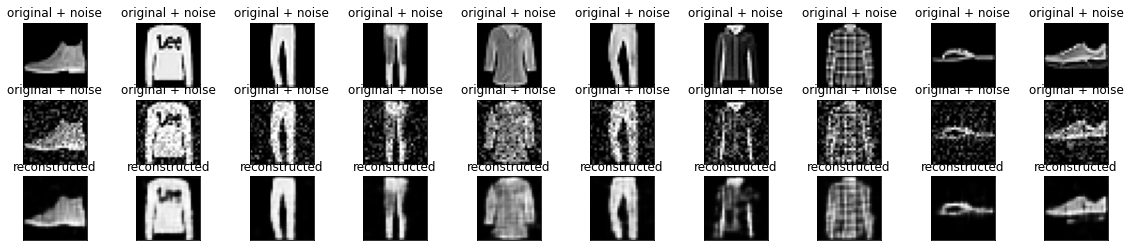

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2 * n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(denoised_images[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

To show that it is not just because we look for what we want to see, let us calculate the MSEs.

In [9]:
mse_noisy_original = np.mean(np.square(x_test_noisy - x_test))
mse_reconstructed_original = np.mean(np.square(denoised_images - x_test))

print(f'MSE of noisy images to original images = {mse_noisy_original}.')
print(f'MSE of reconstructed noisy images to original images = {mse_reconstructed_original}.')

MSE of noisy images to original images = 0.025528831407427788.
MSE of reconstructed noisy images to original images = 0.007175570194295454.


# Exercise 2

Suppose you only longer have access to original images (i.e. without noise) for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the *noisy* test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.

We start by defining an identical autoencoder.

In [10]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', strides=2, input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
], name='encoder')
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same', input_shape=(7, 7, 8)),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same'),
], name='decoder')

In [11]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 7, 7, 8)           1320      
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         1897      
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


Training is different - we train only on original images, but use as validation data the denoised images as targets

In [12]:
autoencoder.fit(x_train, x_train, validation_data=(x_test_noisy, x_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0040 - val_loss: 0.0132
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0029 - val_loss: 0.0137
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0025 - val_loss: 0.0147
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0023 - val_loss: 0.0149
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0022 - val_loss: 0.0149
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0021 - val_loss: 0.0154
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0020 - val_loss: 0.0151
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0020 - val_loss: 0.0153
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.002

Let us encode and decode the noisy test images.

In [13]:
denoised_images = autoencoder.predict(x_test_noisy)

Finally, let us show the results.

Obviously much worse than when we had paired training data, but this is still quite cool. Without ever telling our model how to denoise images, it has learned some - completely "unsupervised"!.

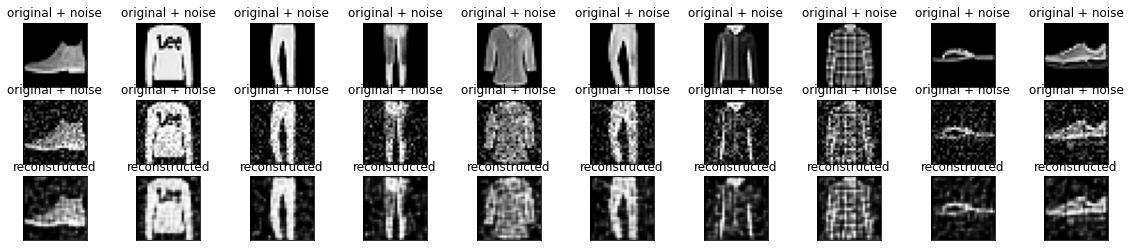

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2 * n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(denoised_images[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

To show that it is not just because we look for what we want to see, let us calculate the MSEs.

In [15]:
mse_noisy_original = np.mean(np.square(x_test_noisy - x_test))
mse_reconstructed_original = np.mean(np.square(denoised_images - x_test))

print(f'MSE of noisy images to original images = {mse_noisy_original}.')
print(f'MSE of reconstructed noisy images to original images = {mse_reconstructed_original}.')

MSE of noisy images to original images = 0.025528831407427788.
MSE of reconstructed noisy images to original images = 0.015569452807649193.


# Exercise 3

Suppose you no longer have access to original images (i.e. without noise) but only the noisy images for training. Train an autoencoder to encode and decode these. Then, use it to encode and decode the noisy test images and see if this helps to remove noise. Note how this is an unsupervised task with respect to noise removal.

We start by defining an identical autoencoder.

In [16]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', strides=2, input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
], name='encoder')
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same', input_shape=(7, 7, 8)),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same'),
], name='decoder')

In [17]:
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 7, 7, 8)           1320      
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         1897      
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


Training is different - we train only on noisy images, but use as validation data the denoised images as targets.

We hope that our autoencoder learns to encode the general information but ignore the noise.

In [18]:
autoencoder.fit(x_train_noisy, x_train_noisy, validation_data=(x_test_noisy, x_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0280 - val_loss: 0.0167
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0155 - val_loss: 0.0163
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0151 - val_loss: 0.0163
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0149 - val_loss: 0.0162
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0147 - val_loss: 0.0163
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0146 - val_loss: 0.0166
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0145 - val_loss: 0.0161
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0145 - val_loss: 0.0163
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.014

Let us encode and decode the noisy test images.

In [19]:
denoised_images = autoencoder.predict(x_test_noisy)

Finally, let us show the results.

Obviously much worse than when we had access to images without noise, but think about how cool this is. Our model *has never seen an image without noise*, but is still able to perform some denoising.

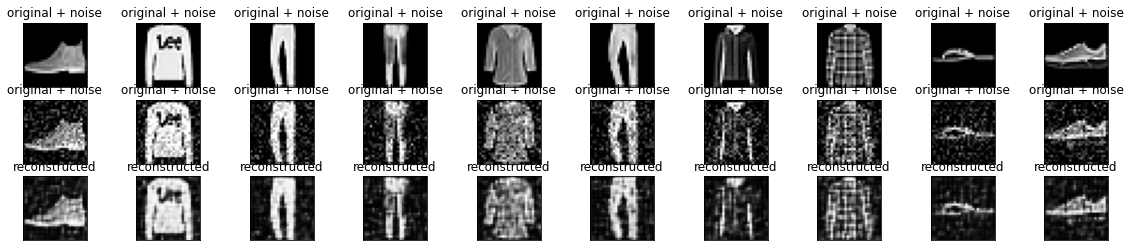

In [20]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2 * n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(denoised_images[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

To show that it is not just because we look for what we want to see, let us calculate the MSEs.

In [21]:
mse_noisy_original = np.mean(np.square(x_test_noisy - x_test))
mse_reconstructed_original = np.mean(np.square(denoised_images - x_test))

print(f'MSE of noisy images to original images = {mse_noisy_original}.')
print(f'MSE of reconstructed noisy images to original images = {mse_reconstructed_original}.')

MSE of noisy images to original images = 0.025528831407427788.
MSE of reconstructed noisy images to original images = 0.01651788566731386.
